## Improving performance with L1/Hessian denoising
**Brett Olsen, March 2023**

### Introduction

I'm going to demonstrate a potentially useful denoising tool for improving performance of ink detection results using any other approach that produces a continuous probability output.
The general approach is to exploit known properties of the ink distribution, in particular that:
1. The ink is sparse; most regions of the papyrus will not contain ink.
2. The ink is continuous; a single pixel is much more likely to contain ink if it is next to another ink-containing pixel.

Suppose we have a noisy array $\boldsymbol{A}$ that contains our initial estimates of where ink is present.
Assuming it is a reasonable estimate, we can approximate it as a convolution of the truth set $\boldsymbol{T}$ with an error distribution $\epsilon$.
We would like to make a new estimate $\boldsymbol{B}$ that minimizes this error term.
With no additional information, we would seek to find
$$
\underset{\boldsymbol{B}}{\operatorname{argmin}} \frac{1}{2}\sum_{i=0}^N(\boldsymbol{A}[i] - \boldsymbol{B}[i])^2.
$$
That is, find the minimum least-square fit of $\boldsymbol{B}$ to $\boldsymbol{A}$.
This is, of course, just $\boldsymbol{A}$.
We can add additional terms to the minimization to account for our additional priors about the ink distribution.
The sparsity condition can be accounted for with a scaled L1-norm regularization term:  we simultaneously wish to minimize the least squared distance between $\boldsymbol{A}$ and $\boldsymbol{B}$ as well as the L1-norm of the denoised signal $\boldsymbol{B}$:
$$
\underset{\boldsymbol{B}}{\operatorname{argmin}} \frac{1}{2}\sum_{i=0}^N(\boldsymbol{A}[i] - \boldsymbol{B}[i])^2 + \lambda \sum_{i=0}^N | \boldsymbol{B}[i] |.
$$

With the single regularization term, this is analytically solvable (proof is left as an exercise for the reader) as the so-called soft-thresholding function:
$$
\boldsymbol{B}[i] = 
\begin{cases}
    |\boldsymbol{A}[i]| \leq \lambda & 0 \\
    \boldsymbol{A}[i] > \lambda & \boldsymbol{A}[i] - \lambda \\
    \boldsymbol{A}[i] < -\lambda & \boldsymbol{A}[i] + \lambda \\
\end{cases}
$$

The continuity condition can be accounted for by adding scaled terms for all the entries in the $2 \times 2$ Hessian matrix of second-order partial derivatives of $\boldsymbol{B}$:

$$
\underset{\boldsymbol{B}}{\operatorname{argmin}} \frac{1}{2}\sum_{i=0}^N(\boldsymbol{A}[i] - \boldsymbol{B}[i])^2 + \lambda \sum_{i=0}^N | \boldsymbol{B}[i] | + \zeta \left [ \frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2} + 2 \frac{\partial^2}{\partial x \partial y} \right ] \boldsymbol{B}[i].
$$

That is, we are penalizing $\boldsymbol{B}$ for having strongly varying values.
Unfortunately, this is no longer analytically solvable, so we will use iterative methods to approach the solution.
See references:
- https://eeweb.engineering.nyu.edu/iselesni/lecture_notes/SALSA/SALSA.pdf
- https://github.com/WeisongZhao/Sparse-SIM

### Data generation and scoring

Let us begin by generating some synthetic data.
We will take the truth set for one of our fragments and convert it to a continuous probability array by adding scaled Gaussian noise.
The level of noise will be adjusted so as to achieve similar performance on the [F0.5 scale](https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/overview/evaluation) used for scoring as the `ink-id` results, of 0.48.

In [1]:
import os
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

INPUT_FOLDER = "/kaggle/input/vesuvius-challenge-ink-detection/train/1/"

cuda


In [63]:
# Attempt to import GPU-accelerated numpy routines
try:
    import cupy as cp
    xp = cp
except ImportError:
    xp = np

In [5]:
pip install cupy

  Using cached cupy-12.0.0.tar.gz (2.0 MB)
  Preparing metadata (setup.py) ... done
  Using cached fastrlock-0.8.1-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_24_x86_64.whl (47 kB)
anceled
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [53]:
mask = xp.array(Image.open(os.path.join(INPUT_FOLDER, "mask.png")), dtype=bool)
truth = xp.array(Image.open(os.path.join(INPUT_FOLDER, "inklabels.png")), dtype=bool)

xslice = slice(3000, 4500, None)
yslice = slice(1000, 2500, None)

mask = mask[xslice, yslice]
truth = truth[xslice, yslice]

def generate_noisy_data(truth, mask, scale=0.25):
    results = xp.zeros_like(truth, dtype=float)
    results[truth] = 1
    results += xp.random.normal(loc=0, scale=scale, size=results.shape)
    results -= results[mask].min()
    results /= results[mask].max()
    results[mask == False] = 0
    return results

In [54]:
noisy = generate_noisy_data(truth, mask, 1.0)

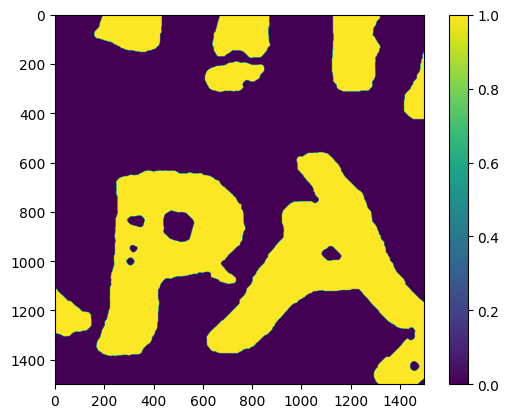

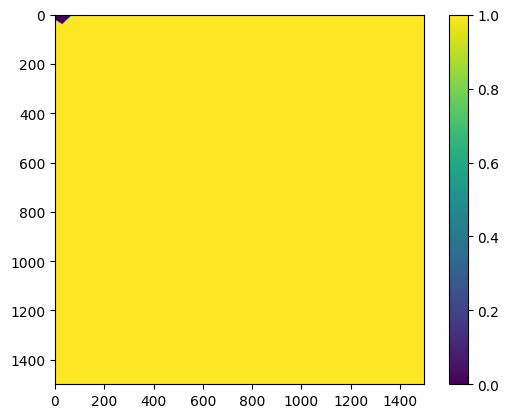

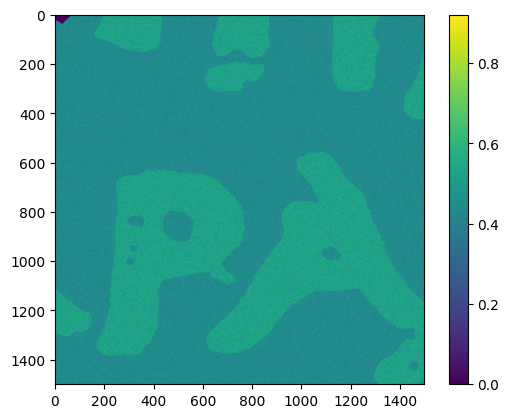

In [80]:
plt.figure()
plt.imshow(truth[:,:,0])
plt.colorbar()

plt.figure()
plt.imshow(mask)
plt.colorbar()

plt.figure()
plt.imshow(noisy[:,:,0])
plt.colorbar()

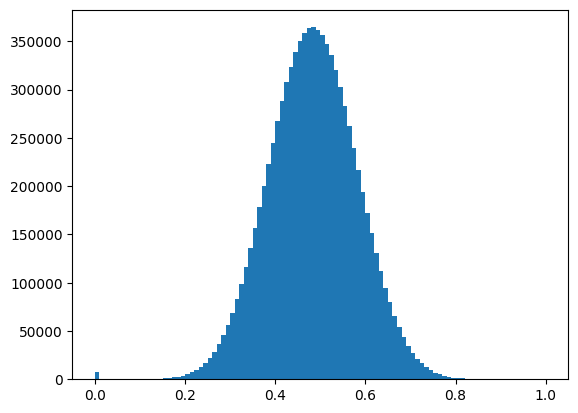

In [81]:
plt.hist(noisy.flatten(), bins=100);

In [66]:
def to_numpy(array):
    if xp == cp:
        return array.get()
    return array

We can do a bit of clever array work to rapidly score our guesses.

In [68]:
def score_guess(guess, truth, beta=0.5, debug=False):
    results = np.zeros_like(guess, dtype=int)
    results[truth] += 1
    results[guess] += 2
    fn = xp.count_nonzero(results == 1)
    fp = xp.count_nonzero(results == 2)
    tp = xp.count_nonzero(results == 3)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    if debug:
        print(f"{tp:,} Correct Pixels")
        print(f"{fp:,} False Positives")
        print(f"{fn:,} False Negatives")
    return (1 + beta ** 2) * precision * recall / (precision * beta ** 2 + recall)

Let's take a look at the scoring of our noisy data as we sweep the calling threshold.

In [69]:
thresholds = xp.linspace(0.4, 0.7, 10)
noisy_masked = noisy[mask]
truth_masked = truth[mask]
scores = xp.array([score_guess(noisy_masked > t, truth_masked) for t in thresholds])

Text(0, 0.5, 'F0.5 Score')

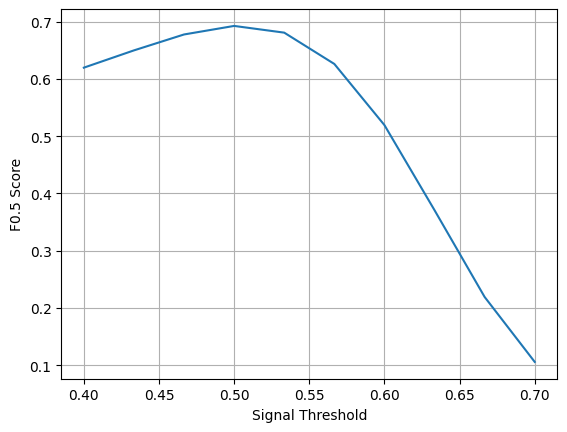

In [70]:
plt.figure()
plt.grid()
plt.plot(to_numpy(thresholds), to_numpy(scores))
plt.xlabel("Signal Threshold")
plt.ylabel("F0.5 Score")

We can see that we're peaking out here around a score of 0.45, pretty close to the `ink-id` score on the leaderboard.
Let's look at the calls we make with the signal threshold of 0.6 here.



In [79]:
best_guess = noisy > 0.55
best_guess_masked = best_guess[mask]
score_guess(best_guess_masked, truth_masked, debug=True)

1,770,936 Correct Pixels
472,681 False Positives
2,679,925 False Negatives


0.6595503171654118

So most of our calls are right, but we're missing almost three times as many as we're calling.

In [ ]:
plt.subplots(1, 2, sharey=True)
plt.subplot(1, 2, 1)
plt.imshow(to_numpy(truth), cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(to_numpy(noisy) > 0.6, cmap="gray")

You can see that what is happening is we're calling many, but not all, pixels inside the inked area, while fewer but not none outside, due to the random noise.

Let's see if we can improve performance on this noisy data.

### Denoising

OK, let's look at the actual denoising code.

In [ ]:
delta_lookup = {
    "xx": xp.array([[1, -2, 1]], dtype=float),
    "yy": xp.array([[1], [-2], [1]], dtype=float),
    "xy": xp.array([[1, -1], [-1, 1]], dtype=float),
}

def operate_derivative(img_shape, pair):
    assert len(img_shape) == 2
    delta = delta_lookup[pair]
    fft = xp.fft.fftn(delta, img_shape)
    return fft * xp.conj(fft)

def soft_threshold(vector, threshold):
    return xp.sign(vector) * xp.maximum(xp.abs(vector) - threshold, 0)

def back_diff(input_image, dim):
    assert dim in (0, 1)
    r, n = xp.shape(input_image)
    size = xp.array((r, n))
    position = xp.zeros(2, dtype=int)
    temp1 = xp.zeros((r+1, n+1), dtype=float)
    temp2 = xp.zeros((r+1, n+1), dtype=float)
    
    temp1[position[0]:size[0], position[1]:size[1]] = input_image
    temp2[position[0]:size[0], position[1]:size[1]] = input_image
    
    size[dim] += 1
    position[dim] += 1
    temp2[position[0]:size[0], position[1]:size[1]] = input_image
    temp1 -= temp2
    size[dim] -= 1
    return temp1[0:size[0], 0:size[1]]

def forward_diff(input_image, dim):
    assert dim in (0, 1)
    r, n = xp.shape(input_image)
    size = xp.array((r, n))
    position = xp.zeros(2, dtype=int)
    temp1 = xp.zeros((r+1, n+1), dtype=float)
    temp2 = xp.zeros((r+1, n+1), dtype=float)
        
    size[dim] += 1
    position[dim] += 1

    temp1[position[0]:size[0], position[1]:size[1]] = input_image
    temp2[position[0]:size[0], position[1]:size[1]] = input_image
    
    size[dim] -= 1
    temp2[0:size[0], 0:size[1]] = input_image
    temp1 -= temp2
    size[dim] += 1
    return -temp1[position[0]:size[0], position[1]:size[1]]

def iter_deriv(input_image, b, scale, mu, dim1, dim2):
    g = back_diff(forward_diff(input_image, dim1), dim2)
    d = soft_threshold(g + b, 1 / mu)
    b = b + (g - d)
    L = scale * back_diff(forward_diff(d - b, dim2), dim1)
    return L, b

def iter_xx(*args):
    return iter_deriv(*args, dim1=1, dim2=1)

def iter_yy(*args):
    return iter_deriv(*args, dim1=0, dim2=0)

def iter_xy(*args):
    return iter_deriv(*args, dim1=0, dim2=1)

def iter_sparse(input_image, bsparse, scale, mu):
    d = soft_threshold(input_image + bsparse, 1 / mu)
    bsparse = bsparse + (input_image - d)
    Lsparse = scale * (d - bsparse)
    return Lsparse, bsparse

def denoise_image(input_image, iter_num=100, fidelity=150, sparsity_scale=10, continuity_scale=0.5, mu=1):
    image_size = xp.shape(input_image)
    #print("Initialize denoising")
    norm_array = (
        operate_derivative(image_size, "xx") + 
        operate_derivative(image_size, "yy") + 
        2 * operate_derivative(image_size, "xy")
    )
    norm_array += (fidelity / mu) + sparsity_scale ** 2
    b_arrays = {
        "xx": xp.zeros(image_size, dtype=float),
        "yy": xp.zeros(image_size, dtype=float),
        "xy": xp.zeros(image_size, dtype=float),
        "L1": xp.zeros(image_size, dtype=float),
    }
    g_update = xp.multiply(fidelity / mu, input_image)
    for i in tqdm(range(iter_num), total=iter_num):
        #print(f"Starting iteration {i+1}")
        g_update = xp.fft.fftn(g_update)
        if i == 0:
            g = xp.fft.ifftn(g_update / (fidelity / mu)).real
        else:
            g = xp.fft.ifftn(xp.divide(g_update, norm_array)).real
        g_update = xp.multiply((fidelity / mu), input_image)
        
        #print("XX update")
        L, b_arrays["xx"] = iter_xx(g, b_arrays["xx"], continuity_scale, mu)
        g_update += L
        
        #print("YY update")
        L, b_arrays["yy"] = iter_yy(g, b_arrays["yy"], continuity_scale, mu)
        g_update += L
        
        #print("XY update")
        L, b_arrays["xy"] = iter_xy(g, b_arrays["xy"], 2 * continuity_scale, mu)
        g_update += L
        
        #print("L1 update")
        L, b_arrays["L1"] = iter_sparse(g, b_arrays["L1"], sparsity_scale, mu)
        g_update += L
        
    g_update = xp.fft.fftn(g_update)
    g = xp.fft.ifftn(xp.divide(g_update, norm_array)).real
    
    g[g < 0] = 0
    g -= g.min()
    g /= g.max()
    return g

In [ ]:
denoised = denoise_image(noisy, iter_num=250)

In [ ]:
plt.figure(figsize=(10, 10))
plt.subplots(1, 2, sharey=True)
plt.subplot(1, 2, 1)
plt.imshow(to_numpy(noisy), cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(to_numpy(denoised), cmap="gray")

In [ ]:
best_guess = noisy > 0.6
best_denoised = denoised > 0.6

plt.subplots(1, 3, sharey=True, figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(to_numpy(truth), cmap="gray")
plt.subplot(1, 3, 2)
plt.imshow(to_numpy(best_guess), cmap="gray")
plt.subplot(1, 3, 3)
plt.imshow(to_numpy(best_denoised), cmap="gray")

In [ ]:
denoised_masked = denoised[mask]
denoised_scores = xp.array([score_guess(denoised_masked > t, truth_masked) for t in thresholds])

In [ ]:
plt.figure()
plt.grid()
plt.plot(to_numpy(thresholds), to_numpy(scores), label="Original")
plt.plot(to_numpy(thresholds), to_numpy(denoised_scores), label="Denoised")
plt.xlabel("Signal Threshold")
plt.ylabel("F0.5 Score")
plt.legend(loc=0)

In [ ]:
best_guess = noisy > 0.53
best_guess_masked = best_guess[mask]
score_guess(best_guess_masked, truth_masked, debug=True)

In [ ]:
best_guess = denoised > 0.53
best_guess_masked = best_guess[mask]
score_guess(best_guess_masked, truth_masked, debug=True)

### Results

Results look promising, at least on the kind of completely random noise I'm modeling here.
We're seeing a significant improvement in score just from this denoising application.
Moreover, we're seeing the improvements across a wide range of thresholds.
We can see that the improvements are across the board:  an increased number of true positives, fewer false positives, and fewer false negatives.

Compared to the previous version, we've significantly improved performance by putting most of the work onto the GPU.
However, the limited memory available on the GPU meant we needed to denoise only a smaller section of the image.
To denoise the entire region, we'd need to chunk and denoise in pieces, but this is perfectly feasible with the ~100x performance improvement from running on the GPU.

For future work:
1. Tuning the parameters for better performance would be useful.  In particular, I think we're probably doing too many iterations and could cut back a bit.  The scale factors for the three components have not been tuned at all, nor has the size of the identity regularization (`fidelity`).
2. The noise model needs to be tested.  Ideally, I'd like to get ahold of actual outputs from various people's machine learning approaches and see if a denoising pass would improve performance.  I'll ask around on the discord.